In [1]:
import os
import json

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

In [14]:
#RESULTS_DIR = os.path.join("P:/early_stopping_double_descent", "...") # enter folder direction here (i.e., two_layer_results)
RESULTS_DIR = "results/five_layer_results" #"two_layer_classification_results"

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the figure title


def get_all_files(lr):
    files = os.listdir(RESULTS_DIR)
    files = [file for file in files if file.startswith(f'lr={lr}') and file.endswith("log.json")]

    return files


def get_files():
    files = os.listdir(RESULTS_DIR)
    files = [file for file in files if file.endswith("log.json")]

    
def append_id(filename, id):
    return "{0}_{2}.{1}".format(*filename.rsplit('.', 1) + [id])


# TODO: clean this up
def get_run_name(lr1, lr2, wd=None, lrdecay=None, norandomflip=True, norandomcrop=True, momentum=True, inv_sqrt_lr=False, track_weights=False):
    
    run_name = f"lr={lr1}_{lr2}"
    
    if not norandomflip:
        run_name += '_r_flip'
        
    if not norandomcrop:
        run_name += '_r_crop'
    
    if wd is not None:
        run_name += f"_wd={wd}"
        
    if lrdecay is not None:
        run_name += f'_ld={lrdecay}'
        
    if track_weights:
        run_name += '_tw'
        
    if not momentum:
        run_name += "_no_momentum"
        
    if inv_sqrt_lr:
        run_name += "_inv_sq_lr"
        
    return run_name
    

def get_filename_individual(lr1, lr2, ext=''):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    
    name = f'lr1={lr1}_lr2={lr2}{ext}.pdf'
    
    return name


def get_filename(lr, vmax):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')

    name = f'{lr}_vmax={vmax}.pdf'
    
    return name


def get_filename_range(lr1, lr2_low, lr2_high):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    
    name = f'lr1={lr1}_lr2_low={lr2_low}_lr2_high=_{lr2_high}.pdf'
        
    return name

def get_save_dir():
    
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  

    return save_dir


In [3]:
def extract_data(file_path, running_avg):
    f = open(file_path)
    data = json.load(f)

    train_acc, test_acc = [], []

    for i, d in enumerate(data):
        train_acc.append(d["train"]["acc1"])
        test_acc.append(d["test"]["acc1"])

    train_err, test_err =  100 - np.array(train_acc), 100 - np.array(test_acc)

    if running_avg:
        train_err, test_err = get_running_avg(train_err), get_running_avg(test_err)
        
    return train_err, test_err


def get_running_avg(x, step=3):
    cumsum = np.cumsum(x) 
    return (cumsum[step:] - cumsum[:-step]) / float(step)


In [10]:
def plot_individual_run(lr1, lr2, wd=None, lrdecay=None, norandomflip=True, norandomcrop=True, momentum=True, inv_sq_lr=False, track_weights=False, running_avg=False):

    run_name = get_run_name(lr1, lr2, wd, lrdecay, norandomflip, norandomcrop, momentum, inv_sq_lr, track_weights)
    file_path = os.path.join(RESULTS_DIR, run_name + "_log.json")
    
    data = extract_data(file_path, running_avg)
    
    cmap = matplotlib.colormaps['viridis']
    colorList = [cmap(50 / 1000), cmap(350 / 1000)]

    fig, ax = plt.subplots(len(data), 1, sharex=True)
    ylabels = ["Train error", "Test error"]
    for k in range(len(data)):
        ax[k].set_xscale('log')
        data_vec = data[k]
        ax[k].plot(np.arange(0, data_vec.shape[0]), data_vec, color=colorList[k], lw=4)
        ax[k].set_ylabel(ylabels[k])
        
    plt.suptitle(fr"$\eta_{{\mathbf{{W}}}} = {lr1}$, $\eta_{{\mathbf{{v}}}} = {lr2}$")
    
    save_dir = get_save_dir()  
        
    plt.savefig(os.path.join(save_dir, get_filename_individual(lr1, lr2)))
    plt.show() 


def plot_results(lr, vmax=100, keep_nan=True, plot_nans=False):
    
    files = get_all_files(lr)

    f_ext = "_log.json"
    lrs = [f.split('_')[1] for f in files]
    
    print(fr'Loading {len(lrs)} files')
    
    #assert len(lrs) == 99, "Something wrong with the amount of files"
    lrs_float = [float(l) for l in lrs]
    lrs_float, lrs = zip(*sorted(zip(lrs_float, lrs)))
    
    num_its = 1000
    train_err, test_err = np.zeros((len(lrs), num_its)), np.zeros((len(lrs), num_its))
    for i, l in enumerate(lrs):
        data = extract_data(os.path.join(RESULTS_DIR, f"lr={lr}_{l}{f_ext}"), running_avg=False)
        train_err[i] = data[0]
        test_err[i] = data[1]
    if (~np.isfinite(risks)).any() and np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0].any():
        print(r"Lr2 with nan/inf, then some lower lr2")
        idx=np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0][-1] + 1
        for j in range(10):
            if plot_nans:
                plot_individual_run(lr, lrs[idx-j])
            else:
                print(lrs[idx-j])
    else:
        print('No nans/inf values')
    ratios = np.array(lrs_float)/lr
            
    fig, ax = plt.subplots(2, 1, sharex=True)
    
    # Plot
    im1 = ax[0].imshow(train_err.transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax, vmin=0)
    im2 = ax[1].imshow(test_err.transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax, vmin=0)
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    plt.suptitle(fr"$\eta_{{\mathbf{{W}}}}={lr}$")
    
    # Save file
    save_dir = get_save_dir() 
        
    figname = get_filename(lr, vmax)
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    return
    

In [5]:
# Function for plotting a selection of curves

def plot_individual_runs_range(lr1, lr_ratio_low, lr_ratio_high, running_avg=False):
    """Plot individual runs within range lr_ratio_low to lr_ratio_high"""
    
    files = get_all_files(lr1)
        
    f_ext = "_log.json"
    lrs = [f.split('_')[1] for f in files]

    # Keep runs only within range
    lr2_low, lr2_high = lr_ratio_low * lr1, lr_ratio_high * lr1
    files = [f for f, lr in zip(files, lrs) if float(lr) >= lr2_low and float(lr) <= lr2_high]
    lrs = [float(lr) for lr in lrs if float(lr) >= lr2_low and float(lr) <= lr2_high]
    lrs.sort()


    fig, ax = plt.subplots(2, 1, sharex=True)
    ylabels = ["Train error", "Test error"]
    epochs = []
    for i, lr in enumerate(lrs):
        data = extract_data(os.path.join(RESULTS_DIR, files[i]), running_avg)       

        for k in range(2):
            if i == 0:
                ax[k].set_xscale('log')
                ax[k].set_ylim([0, 100])
                ax[k].set_ylabel(ylabels[k])
            
            data_vec = data[k] 
            ax[k].plot(np.arange(0, data_vec.shape[0]), data_vec, lw=2)
            
            
    ax[0].legend([fr"$\eta_{{\mathbf{{v}}}} = {lr2}$" for lr2 in lrs])
    fig.suptitle(fr"$\eta_{{\mathbf{{w}}}} = {lr1}$")

    save_dir = get_save_dir()

    plt.savefig(os.path.join(save_dir, get_filename_range(lr1, lr2_low, lr2_high)))
    plt.show()
    


In [6]:
def extract_gradients(file_path):
    
    f = open(file_path)
    data = json.load(f)

    grad_dep_unperm, grad_ind_unperm, grad_dep_perm, grad_ind_perm = [], [], [], []

    for i, d in enumerate(data):
        
        assert "grads" in d, "Gradients not recorded"
        
        grad_dep_unperm.append(np.array([d["grads"]["grad_dep"]["unperm"][key] for key in d["grads"]["grad_dep"]["unperm"]]))
        grad_ind_unperm.append(np.array([d["grads"]["grad_ind"]["unperm"][key] for key in d["grads"]["grad_ind"]["unperm"]]))
        grad_dep_perm.append(np.array([d["grads"]["grad_dep"]["perm"][key] for key in d["grads"]["grad_dep"]["perm"]]))
        grad_ind_perm.append(np.array([d["grads"]["grad_ind"]["perm"][key] for key in d["grads"]["grad_ind"]["perm"]]))
       
    grad_dep_unperm, grad_ind_unperm =  np.row_stack(grad_dep_unperm), np.row_stack(grad_ind_unperm)
    grad_dep_perm, grad_ind_perm =  np.row_stack(grad_dep_perm), np.row_stack(grad_ind_perm)
        
    return grad_dep_unperm, grad_ind_unperm, grad_dep_perm, grad_ind_perm


def plot_gradients_individual_layers(lr1, lr2, wd=None, layers=None, plot_ratios=True):
    
    run_name = get_run_name(lr1, lr2, wd)
    file_path = os.path.join(RESULTS_DIR, run_name + "_log.json")
    
    grad_dep_unperm, grad_ind_unperm, grad_dep_perm, grad_ind_perm = extract_gradients(file_path)
    
    if layers is None:
        layers = [i for i in range(1, grad_dep_unperm.shape[-1] + 1)]
    
    fig, ax = plt.subplots(len(layers), 1, figsize=(5, int(len(layers) * 3)), sharex=True)
    
    if plot_ratios:
        data = [grad_dep_unperm / grad_ind_unperm, grad_dep_perm / grad_ind_perm, grad_dep_unperm / grad_dep_perm, 
                grad_ind_unperm / grad_ind_perm]
        labels = ["Unpermuted (dep/ind)", "Permuted (dep/ind)", "Dependent (unperm/perm)", "Independent (unperm/perm)"]
    else:
        data = [grad_dep_unperm, grad_ind_unperm, grad_dep_perm, grad_ind_perm]
        labels = ["Dep., Unperm", "Ind., Unperm", "Dep., Perm", "Ind., Perm"]
    
    epochs = np.arange(0, grad_dep_unperm.shape[0])
    for i, layer in enumerate(layers):
        ax[i].set_xscale('log')
        ax[i].set_ylabel(f'Layer {layer}')
        
        for data_vec, lab in zip(data, labels): 
            ax[i].plot(epochs, data_vec[:, layer - 1], label=lab)
    
        
    ax[0].legend()
    ax[-1].set_xlabel('epochs')
    fig.suptitle(fr"Grad norm, $\eta_{{\mathbf{{W}}}} = {lr1}$, $\eta_{{\mathbf{{v}}}} = {lr2}$")

    save_dir = get_save_dir()
    plt.savefig(os.path.join(save_dir, get_filename_individual(lr1, lr2, ext='_grads')))
    plt.show()
    
    
def plot_gradients(lr1, lr2, normalised=True):
    file_path = os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}_log.json")
    
    grad_dep_unperm, grad_ind_unperm, grad_dep_perm, grad_ind_perm = extract_gradients(file_path)
    
    fig, ax = plt.subplots(4, 1, figsize=(5, 12), sharex=True)
    
    geo_samples = [int(i) for i in np.geomspace(1, 1000 - 1, num=700)]

    
    im = []
    ylabels = ['Dep, unperm', 'Ind, unperm', 'Dep, perm', 'Ind, perm']
    for i, data_mat in enumerate([grad_dep_unperm, grad_ind_unperm, grad_dep_perm, grad_ind_perm]):
        
        if normalised:
            data_mat = data_mat / (data_mat.max(axis=0, keepdims=True))
            ylabels[i] += ' (Relative)'
            
        im.append(ax[i].imshow(data_mat[geo_samples, :].transpose(), interpolation='none', aspect='auto'))
        ax[i].set_ylabel(ylabels[i])

        fig.colorbar(im[i], ax=ax[i])
        
    # TODO: Set correct x-ticks
    ax[-1].set_xticklabels([])
        
    ax[-1].set_xlabel('epochs (log-scale)')
    fig.suptitle(fr"Grad norm, $\eta_{{\mathbf{{W}}}} = {lr1}$, $\eta_{{\mathbf{{v}}}} = {lr2}$")

    save_dir = get_save_dir()
    
    plt.savefig(os.path.join(save_dir, get_filename_individual(lr1, lr2, ext='_grads_img')))
    plt.show()

In [7]:
def extract_weights(file_path):
    
    f = open(file_path)
    data = json.load(f)

    weight_norm = []

    for i, d in enumerate(data):
        
        assert "w_norm" in d, "Weight norms not recorded"
        
        weight_norm.append(np.array([d["w_norm"][key] for key in d["w_norm"]]))
       
    weight_norm = np.row_stack(weight_norm)
    
    return weight_norm

def plot_weights(lr1, lr2, relative=False):
    file_path = os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}_tw_log.json")
    
    weight_norm = extract_weights(file_path)
    
    fig, ax = plt.subplots(1, 1)
    ax.set_xscale('log')
    ax.set_xlabel('epoch')
    
    if relative:
        weight_norm = weight_norm / weight_norm[0, :]
        ax.set_ylabel(f'weight norm (relative)')
    else:
        ax.set_ylabel(f'weight norm')

    epochs = np.arange(0, weight_norm.shape[0])
    for i in range(weight_norm.shape[-1]):

        ax.plot(epochs, weight_norm[:, i], label = f'Layer {i+1}')
        
    ax.legend()
    
    save_dir = get_save_dir()
    plt.savefig(os.path.join(save_dir, get_filename_individual(lr1, lr2, ext='_weights')))
    plt.show()

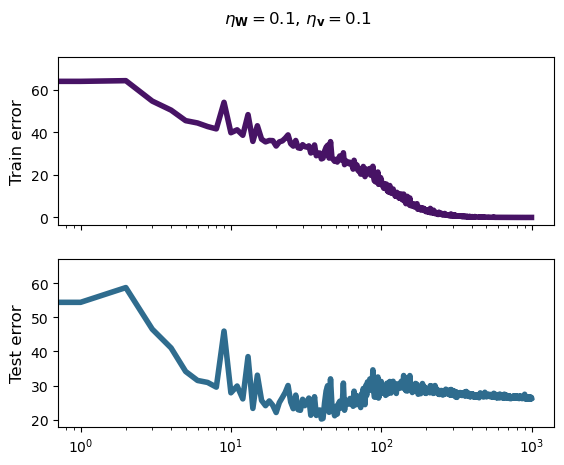

In [15]:
plot_individual_run(0.1, 0.1, wd=None, lrdecay=0.1, norandomflip=False, norandomcrop=False, momentum=False, inv_sq_lr=True, running_avg=False)

In [ ]:
plot_individual_run(0.1, 0.001)

In [ ]:
plot_individual_run(0.1, 1.0)

In [ ]:
plot_individual_run(0.01, 0.1)

In [ ]:
plot_individual_runs_range(0.1, 0.01, 3)

In [ ]:
plot_gradients_individual_layers(0.1, 0.1, layers=None)

In [ ]:
plot_weights(0.1, 0.1, relative=True)

In [ ]:
plot_individual_run(0.1, 0.1, wd=0.0001)

In [ ]:
plot_gradients_individual_layers(0.1, 0.1, layers=[1, 4, 8, 12, 18])

In [ ]:
plot_gradients_individual_layers(0.1, 0.1, wd=0.0001, layers=[1, 4, 8, 12, 18])

In [ ]:
plot_gradients_individual_layers(0.1, 0.1, layers=[1, 4, 8, 12, 18], plot_ratios=False)

In [ ]:
plot_gradients_individual_layers(0.1, 0.1, wd=0.0001, layers=[1, 4, 8, 12, 18], plot_ratios=False)